In [78]:
import matplotlib.pyplot as plt
import numpy as np

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


def RMSE(output, labels):
    return torch.sqrt(torch.mean((output - labels) ** 2)).item()


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
    verbose=True,
    eval_metrics=[accuracy],
    label_idx=-1,
):

    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]

    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
    }
    for eval_metric_name in eval_metric_names:
        history["train"][eval_metric_name] = []
        history["valid"][eval_metric_name] = []

    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = {eval_metric_name: 0 for eval_metric_name in eval_metric_names}
        total = 0
        evaluation_train = {
            "loss": 0,
            **{eval_metric_name: 0 for eval_metric_name in eval_metric_names},
        }

        for idx, data in enumerate(tqdm(train_loader, disable=not verbose)):
            input, labels = data[0].to(device), data[label_idx].to(device)
            # print(input.shape, labels.shape)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                correct[eval_metric_name] += torch.tensor(
                    eval_metric(output, labels)
                ).item() * len(labels)
            total += len(labels)

        for eval_metric_name in eval_metric_names:
            evaluation_train[eval_metric_name] = correct[eval_metric_name] / total

        evaluation_train["loss"] = Loss_epoch / total
        evaluation_valid, *_ = evaluate(
            model,
            valid_loader,
            criterion,
            device,
            eval_metrics=eval_metrics,
            label_idx=label_idx,
        )
        if verbose:
            print(
                f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}"
            )

        for eval_metric_name in eval_metric_names:
            history["train"][eval_metric_name].append(
                evaluation_train[eval_metric_name]
            )
            history["valid"][eval_metric_name].append(
                evaluation_valid[eval_metric_name]
            )

        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])

        if log_writer is not None:
            log_dict = {}
            for eval_metric_name in eval_metric_names:
                log_dict.update(
                    {
                        f"train/train_{eval_metric_name}": (
                            evaluation_train[eval_metric_name],
                            epoch,
                        ),
                        f"val/valid_{eval_metric_name}": (
                            evaluation_valid[eval_metric_name],
                            epoch,
                        ),
                    }
                )

            log_dict.update(
                {
                    "train/train_loss": (evaluation_train["loss"], epoch),
                    "val/valid_loss": (evaluation_valid["loss"], epoch),
                }
            )
            log_writer.log(log_dict)

    return history


def evaluate(
    model,
    data_loader,
    criterion,
    device,
    eval_metrics=[accuracy],
    return_preds=False,
    return_features=False,
    label_idx=-1,
):
    model.eval()
    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]
    metrics = {eval_metric_name: [] for eval_metric_name in eval_metric_names}
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[label_idx].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                metrics[eval_metric_name].append(eval_metric(output, target))

            Loss_history.append(loss.item())
            if return_preds:

                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return (
        {
            **{
                eval_metric_name: torch.mean(
                    torch.Tensor(metrics[eval_metric_name])
                ).item()
                for eval_metric_name in eval_metric_names
            },
            "loss": torch.mean(torch.Tensor(Loss_history)).item(),
        },
        PREDS,
        features,
        ground_truth,
    )

In [80]:
from torchvision.datasets import DatasetFolder, ImageFolder
from skimage import color
from torchvision.transforms import v2 as tt
from torch.utils.data import DataLoader

In [81]:
data_transform = tt.Compose(
    [
        tt.ToImage(),
        tt.Resize(size=(224, 224)),
        tt.RandomHorizontalFlip(p=0.5),
        tt.RandomRotation(degrees=45),
        tt.ToDtype(torch.float32, scale=1 / 255),
    ]
)



from torchvision import datasets



train_data = datasets.ImageFolder(
    root="./hymenoptera_data/train", transform=data_transform, target_transform=None
)



test_data = datasets.ImageFolder(
    root="./hymenoptera_data/val", transform=data_transform
)



print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 RandomRotation(degrees=[-45.0, 45.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                 ToDtype(scale=0.00392156862745098)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./hymenoptera_data/val
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 RandomRotation(degrees=[-45.0, 45.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                 ToDtype(scale=0.00392156862745098)
           )

In [82]:
classes = train_data.classes

In [83]:
def collate_fn_lab(data):
    rgb_images, labels = zip(*data)
    lab_images = [
        torch.tensor(color.rgb2lab(torch.permute(x, (1, 2, 0)))).permute(2, 0, 1)
        for x in rgb_images
    ]
    return torch.stack(lab_images), torch.stack(rgb_images), torch.tensor(labels)

In [84]:
def collate_fn_negative(data):
    rgb_images, labels = zip(*data)
    neg_images = [
        torch.tensor(torch.abs(1 - torch.permute(x, (1, 2, 0)))).permute(2, 0, 1)
        for x in rgb_images
    ]
    return torch.stack(rgb_images), torch.stack(neg_images), torch.tensor(labels)

In [85]:
def collate_fn_flip(data):
    rgb_images, labels = zip(*data)
    flip_images = [
        torch.tensor(
            tt.RandomHorizontalFlip(p=1.0)(torch.permute(x, (1, 2, 0)))
        ).permute(2, 0, 1)
        for x in rgb_images
    ]
    return torch.stack(rgb_images), torch.stack(flip_images), torch.tensor(labels)

In [86]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)


def get_features(model, data_loader, device, get_preds=False):

    model.eval()

    features = []

    labels = []

    preds = []

    with torch.no_grad():

        for idx, data in enumerate(data_loader):

            input, target = data[0].to(device), data[-1].to(device)

            output = model(input, get_features=True)

            if get_preds:

                preds.extend(output[0].tolist())

            features.extend(output[1].tolist())

            labels.extend(target.tolist())
    return features, labels, preds



def plot_TSNE(X, Y, title, writer=None):

    X_embedded = TSNE(
        n_components=2, perplexity=min(20, len(X)), n_iter=1000
    ).fit_transform(X)

    fig = plt.figure(figsize=(8, 8))

    ax = plt.subplot(111)

    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)

    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")

    ax.add_artist(legend1)

    plt.title(f"TSNE model: {title}")

    plt.show()

    if writer is not None:

        writer.add_figure("TSNE", fig, global_step=0)


def plot_PCA(X, Y, title, writer=None):
    X_embedded = PCA(
        n_components=2,
    ).fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    plt.title(f"PCA model: {title}")
    plt.show()
    if writer is not None:
        writer.add_figure("PCA", fig, global_step=0)


def add_pr_curve_tensorboard(
    class_index, classes, test_probs, test_label, writer, global_step=0
):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(
        classes[class_index],
        tensorboard_truth,
        tensorboard_probs,
        global_step=global_step,
    )


def acc_pr_rec(preds, labels, classes, writer, global_step=0):
    preds = np.array(preds)
    labels = np.array(labels)
    preds_ = np.argmax(preds, axis=1)
    for i in range(len(classes)):
        add_pr_curve_tensorboard(i, classes, preds, labels, writer, global_step)
    writer.add_scalar(
        "Accuracy", ac := accuracy_score(labels, preds_), global_step=global_step
    )
    writer.add_scalar(
        "Precision",
        pr := precision_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.add_scalar(
        "Recall",
        rec := recall_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.add_scalar(
        "F1",
        f1 := f1_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.close()
    return ac, pr, rec, f1


def plot_ConfusionMatrix(preds, labels, classes, title, writer, global_step=0):
    cm = confusion_matrix(labels, np.argmax(preds, axis=1), normalize="true")
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    plt.title(f"Model: {title}")
    plt.show()
    writer.add_figure("ConfusionMatrix", fig, global_step=global_step)
    writer.close()
    return cm

--------------------
Task: lab
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_8052\697319802.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct[eval_metric_name] += torch.tensor(
100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


epoch: 0, train: {'loss': 0.2019962789338143, 'RMSE': 0.41614563103582036, 'StructuralSimilarityIndexMeasure': 0.2319821901008731, 'PeakSignalNoiseRatio': 8.282917679333297}, valid: {'RMSE': 0.3086961805820465, 'StructuralSimilarityIndexMeasure': 0.2960389256477356, 'PeakSignalNoiseRatio': 10.29768180847168, 'loss': 0.09754254668951035}


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


epoch: 1, train: {'loss': 0.05022142454981804, 'RMSE': 0.22378657000963806, 'StructuralSimilarityIndexMeasure': 0.38097263261920117, 'PeakSignalNoiseRatio': 13.015909101142258}, valid: {'RMSE': 0.22106488049030304, 'StructuralSimilarityIndexMeasure': 0.3896555006504059, 'PeakSignalNoiseRatio': 13.158090591430664, 'loss': 0.04949990287423134}


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


epoch: 2, train: {'loss': 0.03570492657237365, 'RMSE': 0.18874514347217122, 'StructuralSimilarityIndexMeasure': 0.4038164322493506, 'PeakSignalNoiseRatio': 14.49211256621314}, valid: {'RMSE': 0.18447847664356232, 'StructuralSimilarityIndexMeasure': 0.41336625814437866, 'PeakSignalNoiseRatio': 14.714632034301758, 'loss': 0.03433055058121681}


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


epoch: 3, train: {'loss': 0.030985523381682693, 'RMSE': 0.17566244157611346, 'StructuralSimilarityIndexMeasure': 0.4190770456048309, 'PeakSignalNoiseRatio': 15.124024328638296}, valid: {'RMSE': 0.170260950922966, 'StructuralSimilarityIndexMeasure': 0.4301266670227051, 'PeakSignalNoiseRatio': 15.388826370239258, 'loss': 0.029062291607260704}


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


epoch: 4, train: {'loss': 0.027679156695233017, 'RMSE': 0.1662032020385148, 'StructuralSimilarityIndexMeasure': 0.43070528448605144, 'PeakSignalNoiseRatio': 15.595703422046098}, valid: {'RMSE': 0.16498449444770813, 'StructuralSimilarityIndexMeasure': 0.4354081153869629, 'PeakSignalNoiseRatio': 15.66435432434082, 'loss': 0.027302036061882973}


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


epoch: 5, train: {'loss': 0.028043251759448988, 'RMSE': 0.16733527330101514, 'StructuralSimilarityIndexMeasure': 0.43472069208739234, 'PeakSignalNoiseRatio': 15.534654867453654}, valid: {'RMSE': 0.1622660607099533, 'StructuralSimilarityIndexMeasure': 0.44080042839050293, 'PeakSignalNoiseRatio': 15.807385444641113, 'loss': 0.026401519775390625}


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


epoch: 6, train: {'loss': 0.026698876905148147, 'RMSE': 0.1633156086089181, 'StructuralSimilarityIndexMeasure': 0.4410978389568016, 'PeakSignalNoiseRatio': 15.743865779188813}, valid: {'RMSE': 0.16112592816352844, 'StructuralSimilarityIndexMeasure': 0.4410012364387512, 'PeakSignalNoiseRatio': 15.871190071105957, 'loss': 0.02604585327208042}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 7, train: {'loss': 0.027772827684635022, 'RMSE': 0.16551440319076913, 'StructuralSimilarityIndexMeasure': 0.44416684351983615, 'PeakSignalNoiseRatio': 15.67633053513824}, valid: {'RMSE': 0.15893028676509857, 'StructuralSimilarityIndexMeasure': 0.45015963912010193, 'PeakSignalNoiseRatio': 15.986859321594238, 'loss': 0.025321906432509422}


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


epoch: 8, train: {'loss': 0.02574983434598954, 'RMSE': 0.1604115384035423, 'StructuralSimilarityIndexMeasure': 0.4493327267834398, 'PeakSignalNoiseRatio': 15.898313616142898}, valid: {'RMSE': 0.15839645266532898, 'StructuralSimilarityIndexMeasure': 0.44976624846458435, 'PeakSignalNoiseRatio': 16.018098831176758, 'loss': 0.025162946432828903}


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


epoch: 9, train: {'loss': 0.024904286091933486, 'RMSE': 0.15774358173862832, 'StructuralSimilarityIndexMeasure': 0.455663156802537, 'PeakSignalNoiseRatio': 16.0446729191014}, valid: {'RMSE': 0.15609028935432434, 'StructuralSimilarityIndexMeasure': 0.45338940620422363, 'PeakSignalNoiseRatio': 16.144805908203125, 'loss': 0.024431928992271423}


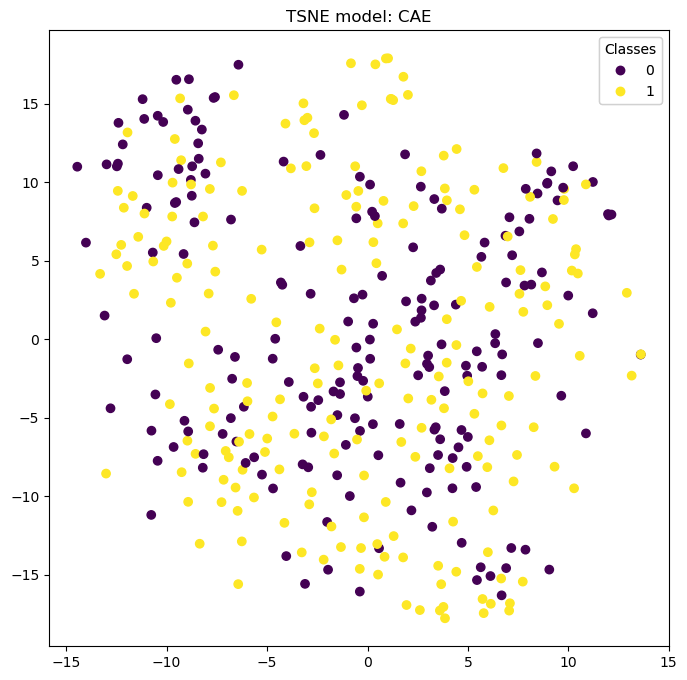

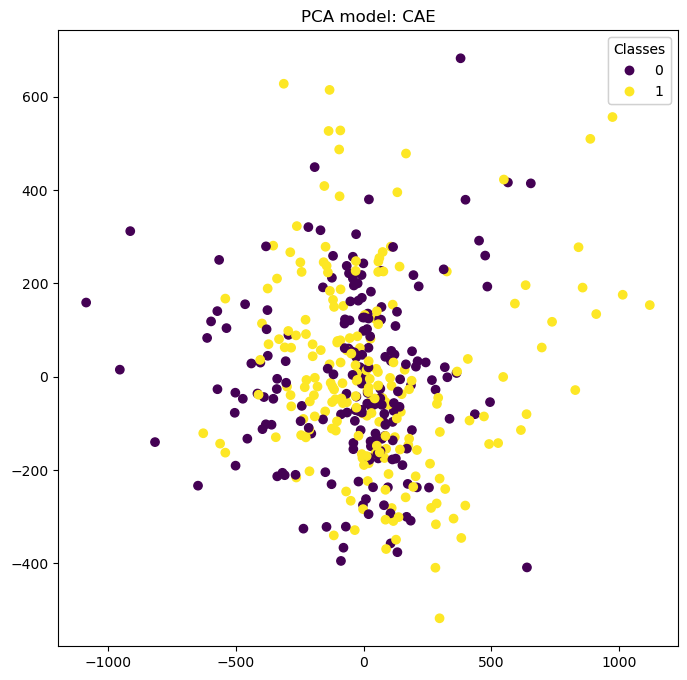

c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


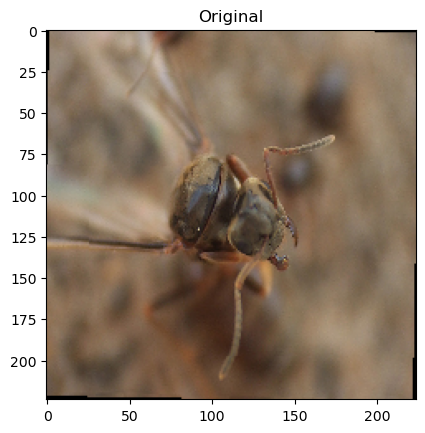

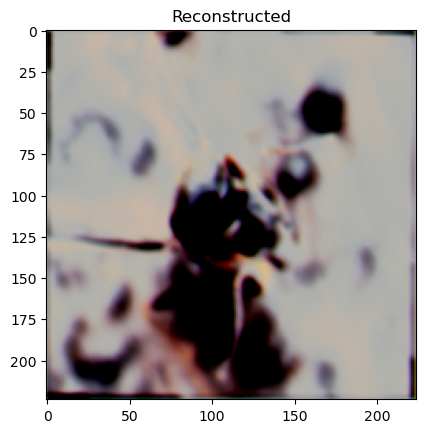

********************
Simple MLP Transfer Learning
********************


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


epoch: 0, train: {'loss': 0.7542652995859991, 'accuracy': 0.5573770496688906}, valid: {'accuracy': 0.48124998807907104, 'loss': 0.8319756388664246}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 1, train: {'loss': 0.7608756530480306, 'accuracy': 0.5491803268917271}, valid: {'accuracy': 0.518750011920929, 'loss': 0.7931380271911621}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 2, train: {'loss': 0.7536283672833052, 'accuracy': 0.5614754108131909}, valid: {'accuracy': 0.4437499940395355, 'loss': 0.8703605532646179}


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


epoch: 3, train: {'loss': 0.755971441503431, 'accuracy': 0.5573770491803278}, valid: {'accuracy': 0.48750001192092896, 'loss': 0.8215239644050598}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 4, train: {'loss': 0.7828995458415298, 'accuracy': 0.5286885265444146}, valid: {'accuracy': 0.48750001192092896, 'loss': 0.8260065317153931}


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


epoch: 5, train: {'loss': 0.78494288295996, 'accuracy': 0.5286885245901639}, valid: {'accuracy': 0.4437499940395355, 'loss': 0.865217387676239}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 6, train: {'loss': 0.8084617042150654, 'accuracy': 0.5040983606557377}, valid: {'accuracy': 0.4625000059604645, 'loss': 0.8512110710144043}


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


epoch: 7, train: {'loss': 0.8097426930411917, 'accuracy': 0.5040983626099883}, valid: {'accuracy': 0.4937500059604645, 'loss': 0.8165079355239868}


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


epoch: 8, train: {'loss': 0.7257323958834664, 'accuracy': 0.5901639363804801}, valid: {'accuracy': 0.5062500238418579, 'loss': 0.8081076741218567}


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


epoch: 9, train: {'loss': 0.7062719552243342, 'accuracy': 0.6065573750949297}, valid: {'accuracy': 0.543749988079071, 'loss': 0.7658774852752686}
test accuracy: 0.5490196078431373, test loss: 0.7664566040039062
Precision: 0.5678801466139995, Recall: 0.5490196078431373, F1: 0.5432042578475621
--------------------


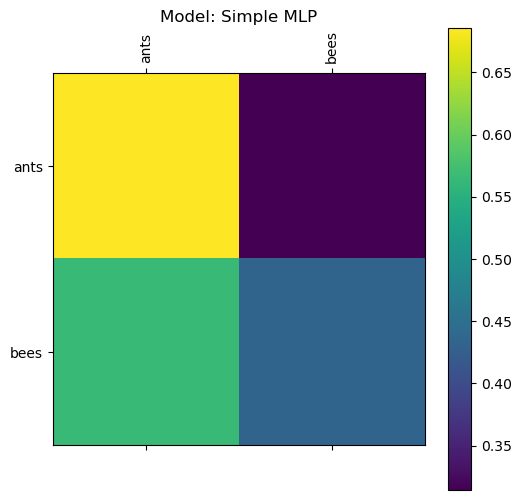

Average Accuracy: 0.5490196078431373, Average Loss: 0.7664566040039062, Average Precision: 0.5678801466139995, Average Recall: 0.5490196078431373
--------------------
Task: negative
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_8052\1930123868.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

epoch: 0, train: {'loss': 0.33639923764056845, 'RMSE': 0.5747020185970869, 'StructuralSimilarityIndexMeasure': 0.12875006189111804, 'PeakSignalNoiseRatio': 4.885748808501197}, valid: {'RMSE': 0.5704593658447266, 'StructuralSimilarityIndexMeasure': 0.15627355873584747, 'PeakSignalNoiseRatio': 4.891127109527588, 'loss': 0.32657745480537415}


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


epoch: 1, train: {'loss': 0.2217202440637057, 'RMSE': 0.4704968470041869, 'StructuralSimilarityIndexMeasure': 0.24637124137800248, 'PeakSignalNoiseRatio': 6.555672465777788}, valid: {'RMSE': 0.42887282371520996, 'StructuralSimilarityIndexMeasure': 0.3291993737220764, 'PeakSignalNoiseRatio': 7.369008541107178, 'loss': 0.18458500504493713}


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


epoch: 2, train: {'loss': 0.18494922753240242, 'RMSE': 0.4288796196218397, 'StructuralSimilarityIndexMeasure': 0.28156545513966047, 'PeakSignalNoiseRatio': 7.3781274107636}, valid: {'RMSE': 0.3176582455635071, 'StructuralSimilarityIndexMeasure': 0.4583047926425934, 'PeakSignalNoiseRatio': 9.972326278686523, 'loss': 0.10117574036121368}


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


epoch: 3, train: {'loss': 0.0796300014022921, 'RMSE': 0.2806292283730429, 'StructuralSimilarityIndexMeasure': 0.3867244788857757, 'PeakSignalNoiseRatio': 11.082993960771404}, valid: {'RMSE': 0.23743095993995667, 'StructuralSimilarityIndexMeasure': 0.47261589765548706, 'PeakSignalNoiseRatio': 12.52318000793457, 'loss': 0.05679042264819145}


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


epoch: 4, train: {'loss': 0.05724068132580304, 'RMSE': 0.23891726185063847, 'StructuralSimilarityIndexMeasure': 0.4223821783652071, 'PeakSignalNoiseRatio': 12.447337494521845}, valid: {'RMSE': 0.22238847613334656, 'StructuralSimilarityIndexMeasure': 0.4611179232597351, 'PeakSignalNoiseRatio': 13.101399421691895, 'loss': 0.0499437041580677}


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


epoch: 5, train: {'loss': 0.05235008003770328, 'RMSE': 0.2282920211065011, 'StructuralSimilarityIndexMeasure': 0.43694363705447464, 'PeakSignalNoiseRatio': 12.849578857421875}, valid: {'RMSE': 0.22024616599082947, 'StructuralSimilarityIndexMeasure': 0.45090192556381226, 'PeakSignalNoiseRatio': 13.194742202758789, 'loss': 0.049082107841968536}


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


epoch: 6, train: {'loss': 0.047776696379067465, 'RMSE': 0.21803046030099274, 'StructuralSimilarityIndexMeasure': 0.4500065079477967, 'PeakSignalNoiseRatio': 13.252223264975626}, valid: {'RMSE': 0.21350283920764923, 'StructuralSimilarityIndexMeasure': 0.4567973017692566, 'PeakSignalNoiseRatio': 13.476104736328125, 'loss': 0.04622625559568405}


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


epoch: 7, train: {'loss': 0.04558265612262194, 'RMSE': 0.2130868649873577, 'StructuralSimilarityIndexMeasure': 0.4571813213043526, 'PeakSignalNoiseRatio': 13.445912533119076}, valid: {'RMSE': 0.20834727585315704, 'StructuralSimilarityIndexMeasure': 0.46032267808914185, 'PeakSignalNoiseRatio': 13.693037033081055, 'loss': 0.044061072170734406}


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


epoch: 8, train: {'loss': 0.04275184344561374, 'RMSE': 0.20649095099480425, 'StructuralSimilarityIndexMeasure': 0.4647423830188689, 'PeakSignalNoiseRatio': 13.713565075983766}, valid: {'RMSE': 0.20608213543891907, 'StructuralSimilarityIndexMeasure': 0.4610794484615326, 'PeakSignalNoiseRatio': 13.780929565429688, 'loss': 0.04305072873830795}


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


epoch: 9, train: {'loss': 0.04204702139145038, 'RMSE': 0.20450920208555753, 'StructuralSimilarityIndexMeasure': 0.4698260299495009, 'PeakSignalNoiseRatio': 13.80895284746514}, valid: {'RMSE': 0.2000989466905594, 'StructuralSimilarityIndexMeasure': 0.4690510332584381, 'PeakSignalNoiseRatio': 14.036170959472656, 'loss': 0.0405840240418911}


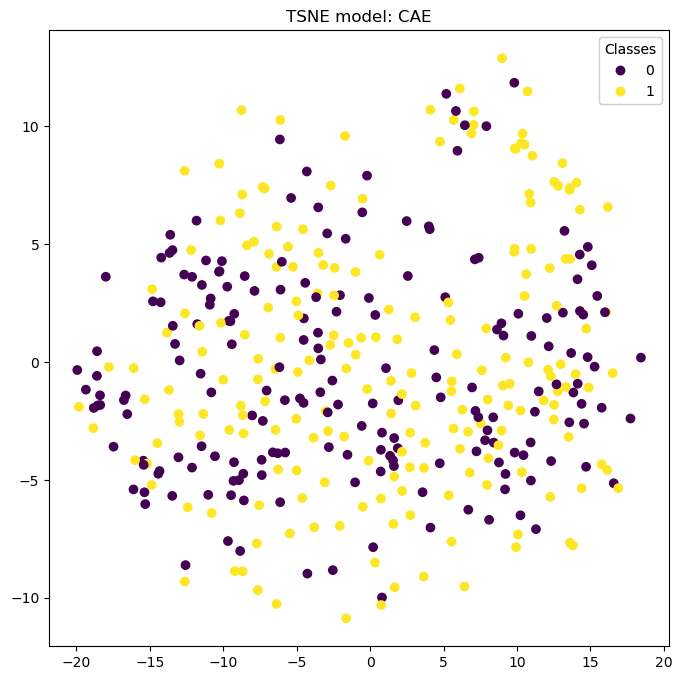

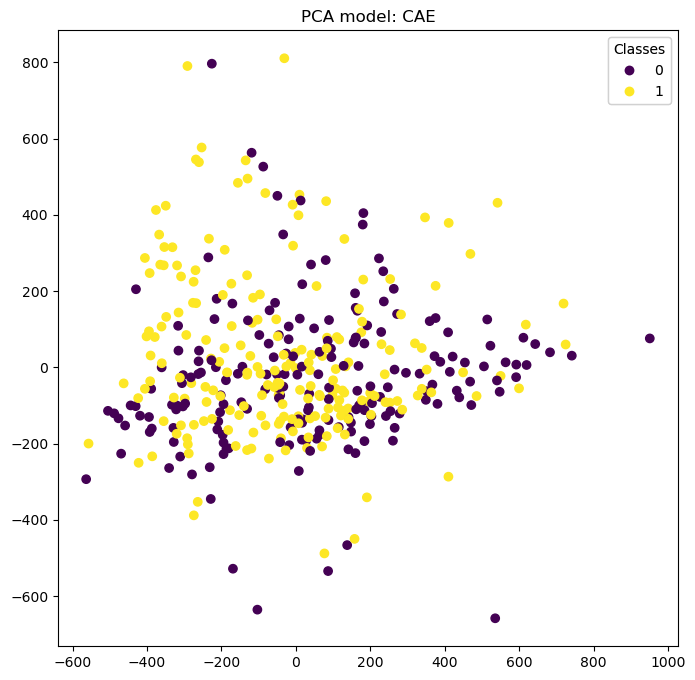

c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_8052\1930123868.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

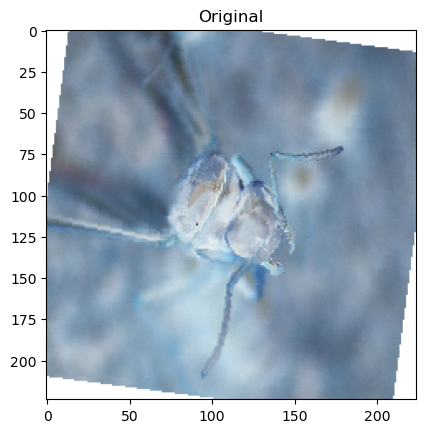

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


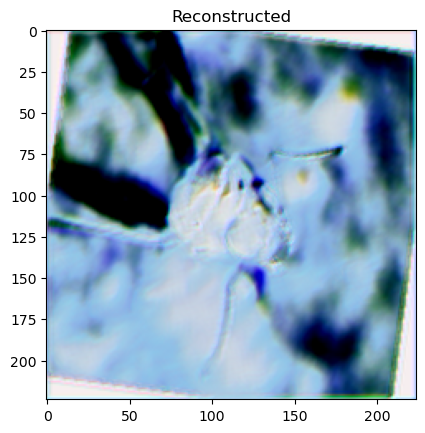

********************
Simple MLP Transfer Learning
********************


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


epoch: 0, train: {'loss': 0.7523932828277838, 'accuracy': 0.5573770472260772}, valid: {'accuracy': 0.5625, 'loss': 0.7469925284385681}


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


epoch: 1, train: {'loss': 0.7127098548607748, 'accuracy': 0.5983606567148303}, valid: {'accuracy': 0.5062500238418579, 'loss': 0.8052705526351929}


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


epoch: 2, train: {'loss': 0.7054855725804313, 'accuracy': 0.6106557357506673}, valid: {'accuracy': 0.625, 'loss': 0.6896952986717224}


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


epoch: 3, train: {'loss': 0.7351335951539336, 'accuracy': 0.5737704922918414}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.7108224034309387}


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


epoch: 4, train: {'loss': 0.6922936380886641, 'accuracy': 0.6188524599935188}, valid: {'accuracy': 0.612500011920929, 'loss': 0.6977751851081848}


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


epoch: 5, train: {'loss': 0.7041370223780148, 'accuracy': 0.6106557386820434}, valid: {'accuracy': 0.606249988079071, 'loss': 0.7015253901481628}


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


epoch: 6, train: {'loss': 0.7084775498655976, 'accuracy': 0.6024590163934426}, valid: {'accuracy': 0.606249988079071, 'loss': 0.7076888084411621}


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


epoch: 7, train: {'loss': 0.7190903884465577, 'accuracy': 0.5942622931277166}, valid: {'accuracy': 0.543749988079071, 'loss': 0.7691842913627625}


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


epoch: 8, train: {'loss': 0.6990825455696856, 'accuracy': 0.6147540983606558}, valid: {'accuracy': 0.5874999761581421, 'loss': 0.7253559827804565}


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


epoch: 9, train: {'loss': 0.6864503856565132, 'accuracy': 0.6229508216263818}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.7146612405776978}
test accuracy: 0.5816993464052288, test loss: 0.7315019965171814
Precision: 0.6511186643032485, Recall: 0.5816993464052288, F1: 0.553250404104294
--------------------


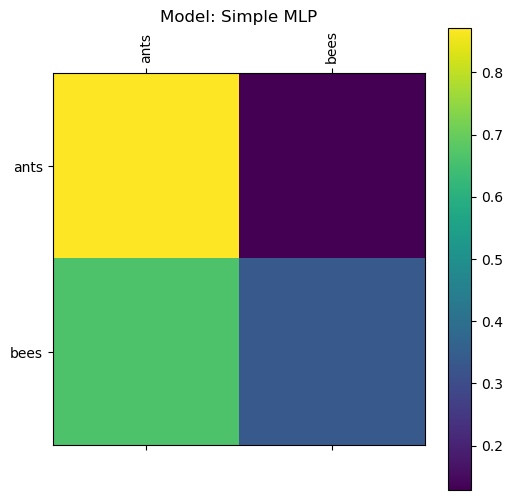

Average Accuracy: 0.5816993464052288, Average Loss: 0.7315019965171814, Average Precision: 0.6511186643032485, Average Recall: 0.5816993464052288
--------------------
Task: flip
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_8052\1151678755.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

epoch: 0, train: {'loss': 0.2533654768447407, 'RMSE': 0.49780853263667374, 'StructuralSimilarityIndexMeasure': 0.19736367464065552, 'PeakSignalNoiseRatio': 6.1468032774378045}, valid: {'RMSE': 0.4052199423313141, 'StructuralSimilarityIndexMeasure': 0.22037431597709656, 'PeakSignalNoiseRatio': 7.927864074707031, 'loss': 0.16792790591716766}


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


epoch: 1, train: {'loss': 0.15897300399717737, 'RMSE': 0.3985062192697994, 'StructuralSimilarityIndexMeasure': 0.2627878150001901, 'PeakSignalNoiseRatio': 7.9958993880475155}, valid: {'RMSE': 0.39685457944869995, 'StructuralSimilarityIndexMeasure': 0.2367335557937622, 'PeakSignalNoiseRatio': 8.119537353515625, 'loss': 0.16181392967700958}


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


epoch: 2, train: {'loss': 0.13575861590807556, 'RMSE': 0.3683154666032947, 'StructuralSimilarityIndexMeasure': 0.2849473484226915, 'PeakSignalNoiseRatio': 8.678848454209625}, valid: {'RMSE': 0.38188010454177856, 'StructuralSimilarityIndexMeasure': 0.2620193660259247, 'PeakSignalNoiseRatio': 8.4483060836792, 'loss': 0.14949563145637512}


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


epoch: 3, train: {'loss': 0.12353507172865946, 'RMSE': 0.3512265828789258, 'StructuralSimilarityIndexMeasure': 0.3082114721907944, 'PeakSignalNoiseRatio': 9.094318733840693}, valid: {'RMSE': 0.37006932497024536, 'StructuralSimilarityIndexMeasure': 0.33476710319519043, 'PeakSignalNoiseRatio': 8.722102165222168, 'loss': 0.14055918157100677}


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


epoch: 4, train: {'loss': 0.11786601912291324, 'RMSE': 0.34317678603969637, 'StructuralSimilarityIndexMeasure': 0.3312311993270624, 'PeakSignalNoiseRatio': 9.293158656261006}, valid: {'RMSE': 0.3554399013519287, 'StructuralSimilarityIndexMeasure': 0.34892183542251587, 'PeakSignalNoiseRatio': 9.057801246643066, 'loss': 0.12897813320159912}


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


epoch: 5, train: {'loss': 0.11348566119788123, 'RMSE': 0.3367284423992282, 'StructuralSimilarityIndexMeasure': 0.34504467493197954, 'PeakSignalNoiseRatio': 9.458175080721496}, valid: {'RMSE': 0.34259843826293945, 'StructuralSimilarityIndexMeasure': 0.3714612126350403, 'PeakSignalNoiseRatio': 9.358633041381836, 'loss': 0.11906477063894272}


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


epoch: 6, train: {'loss': 0.10912479289242479, 'RMSE': 0.33008649603265233, 'StructuralSimilarityIndexMeasure': 0.3564838043978957, 'PeakSignalNoiseRatio': 9.634256441085064}, valid: {'RMSE': 0.3293861746788025, 'StructuralSimilarityIndexMeasure': 0.39128464460372925, 'PeakSignalNoiseRatio': 9.684518814086914, 'loss': 0.10953434556722641}


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


epoch: 7, train: {'loss': 0.1028682850911969, 'RMSE': 0.32029616490739293, 'StructuralSimilarityIndexMeasure': 0.36493296994537605, 'PeakSignalNoiseRatio': 9.900521481623414}, valid: {'RMSE': 0.3091188073158264, 'StructuralSimilarityIndexMeasure': 0.3869379162788391, 'PeakSignalNoiseRatio': 10.222977638244629, 'loss': 0.09609721601009369}


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


epoch: 8, train: {'loss': 0.07734569345341354, 'RMSE': 0.2776078151874855, 'StructuralSimilarityIndexMeasure': 0.39459296523547566, 'PeakSignalNoiseRatio': 11.147025936939677}, valid: {'RMSE': 0.22998996078968048, 'StructuralSimilarityIndexMeasure': 0.43929043412208557, 'PeakSignalNoiseRatio': 12.776054382324219, 'loss': 0.05302133038640022}


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


epoch: 9, train: {'loss': 0.05595527430538271, 'RMSE': 0.2362735032058153, 'StructuralSimilarityIndexMeasure': 0.4357677160716448, 'PeakSignalNoiseRatio': 12.542057944125817}, valid: {'RMSE': 0.2094229906797409, 'StructuralSimilarityIndexMeasure': 0.4577961564064026, 'PeakSignalNoiseRatio': 13.588483810424805, 'loss': 0.043946828693151474}


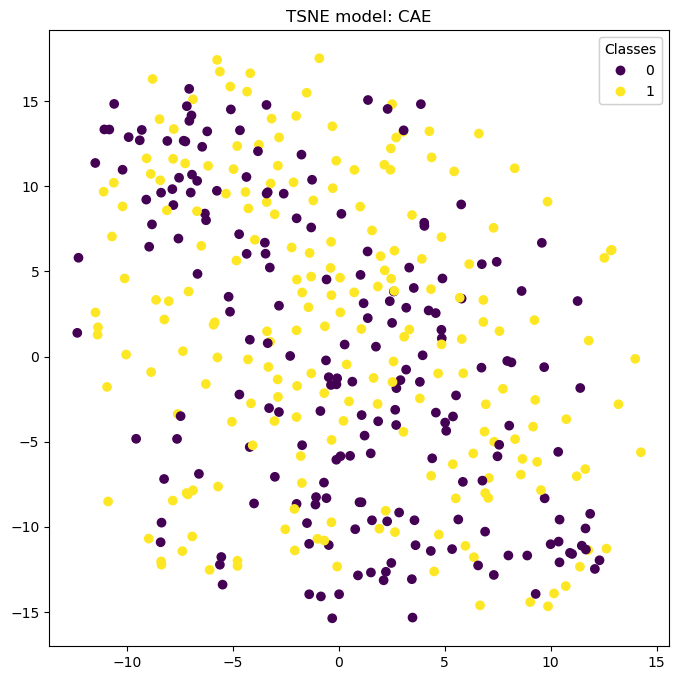

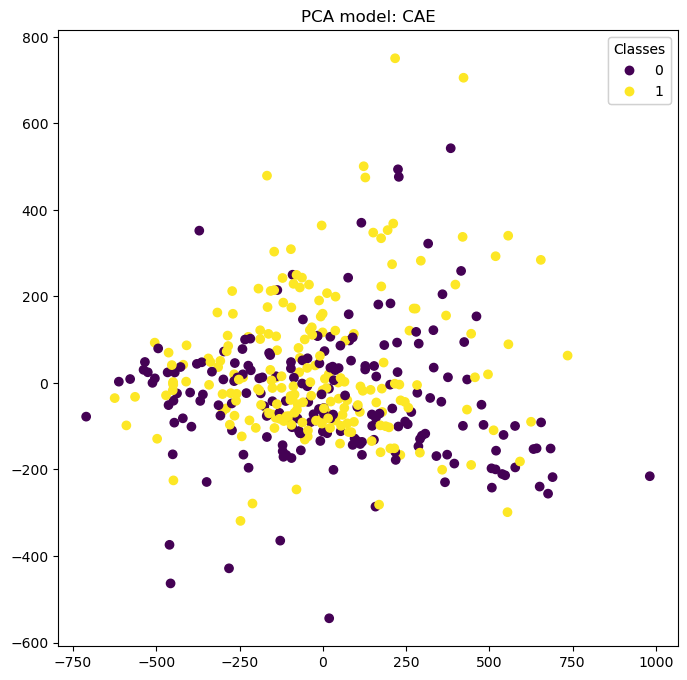

c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_8052\1151678755.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

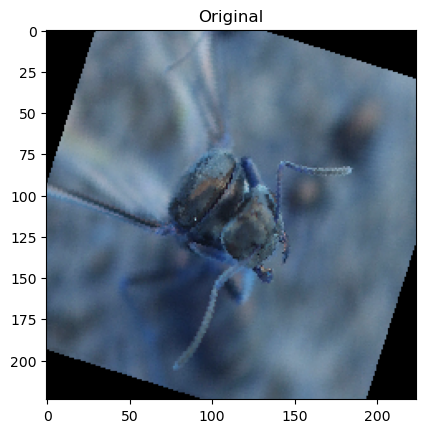

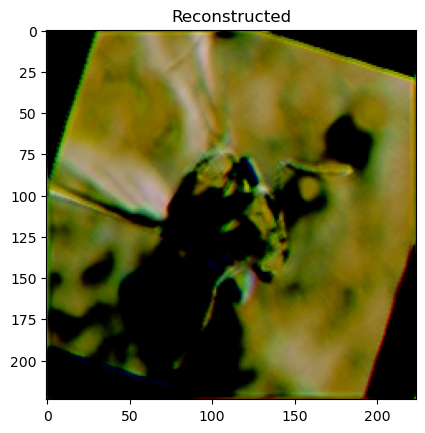

********************
Simple MLP Transfer Learning
********************


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


epoch: 0, train: {'loss': 0.8415411026751409, 'accuracy': 0.4508196726197102}, valid: {'accuracy': 0.4312500059604645, 'loss': 0.8819968104362488}


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


epoch: 1, train: {'loss': 0.804727882635398, 'accuracy': 0.5081967213114754}, valid: {'accuracy': 0.4375, 'loss': 0.8758302927017212}


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


epoch: 2, train: {'loss': 0.8043964739705696, 'accuracy': 0.5081967213114754}, valid: {'accuracy': 0.44999998807907104, 'loss': 0.8632248640060425}


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


epoch: 3, train: {'loss': 0.7969402680631543, 'accuracy': 0.5163934445772015}, valid: {'accuracy': 0.45625001192092896, 'loss': 0.858359694480896}


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


epoch: 4, train: {'loss': 0.7843347602203244, 'accuracy': 0.5286885241016013}, valid: {'accuracy': 0.4437499940395355, 'loss': 0.8694444894790649}


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


epoch: 5, train: {'loss': 0.7831287423118216, 'accuracy': 0.5286885236130386}, valid: {'accuracy': 0.4749999940395355, 'loss': 0.8380864262580872}


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


epoch: 6, train: {'loss': 0.7944328677458842, 'accuracy': 0.5204918042558139}, valid: {'accuracy': 0.4937500059604645, 'loss': 0.8156198263168335}


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


epoch: 7, train: {'loss': 0.7218136259766875, 'accuracy': 0.5901639344262295}, valid: {'accuracy': 0.5562499761581421, 'loss': 0.7560857534408569}


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


epoch: 8, train: {'loss': 0.735044747102456, 'accuracy': 0.5737704908261534}, valid: {'accuracy': 0.5874999761581421, 'loss': 0.7330201864242554}


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


epoch: 9, train: {'loss': 0.8055546615944534, 'accuracy': 0.5081967213114754}, valid: {'accuracy': 0.5625, 'loss': 0.7506946325302124}
test accuracy: 0.5424836601307189, test loss: 0.7707778215408325
Precision: 0.2942885215088214, Recall: 0.5424836601307189, F1: 0.38157748975296335
--------------------


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


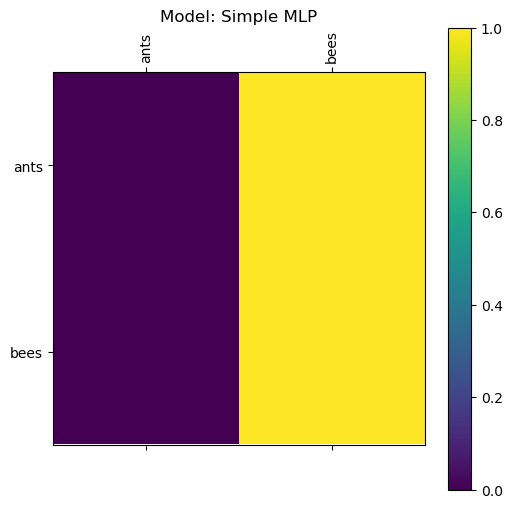

Average Accuracy: 0.5424836601307189, Average Loss: 0.7707778215408325, Average Precision: 0.2942885215088214, Average Recall: 0.5424836601307189


In [87]:
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torch.utils.tensorboard import SummaryWriter


class custom_summary_writer:
    def __init__(self, writer):
        self.writer = writer

    def log(self, metrics):
        for key, value in metrics.items():
            self.writer.add_scalar(key, *(value))


class SimpleMLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fc_in = nn.Linear(in_features=397832, out_features=512)
        self.fc_out = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x, get_features=False):
        x = nn.Flatten()(x)
        x = self.fc_in(x)
        x = F.relu(x)
        x = self.fc_out(x)
        x = F.softmax(x, dim=1)
        if get_features:
            return x, None
        return x


class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim=300):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.LeakyReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.LeakyReLU(True),
            nn.AvgPool2d(2, stride=1),
            nn.BatchNorm2d(8),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 2, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
        )

    def forward(self, x, get_features=False):
        y = self.encoder(x)
        x = self.decoder(y)
        if get_features:
            return x, y
        return x


for task, collat_fn in {
    "lab": collate_fn_lab,
    "negative": collate_fn_negative,
    "flip": collate_fn_flip,
}.items():
    print("-" * 20)
    print(f"Task: {task}")
    print("-" * 20)
    writer = custom_summary_writer(SummaryWriter(f"runs/CAE/task_{task}"))

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=32,
        shuffle=True,
        collate_fn=collat_fn,
    )

    test_loader = DataLoader(
        dataset=test_data,
        batch_size=8,
        shuffle=False,
        collate_fn=collat_fn,
    )

    train_loader, test_loader

    model = ConvAutoEncoder()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    device = "cuda"
    # writer = None
    verbose = True
    history = train(
        model,
        train_loader,
        test_loader,
        optimizer,
        criterion,
        device,
        epochs=10,
        log_writer=writer,
        verbose=True,
        eval_metrics=[
            RMSE,
            StructuralSimilarityIndexMeasure(data_range=1.0).to(device),
            PeakSignalNoiseRatio().to(device),
        ],
        label_idx=-2,
    )
    features_train_data, train_labels, _ = get_features(model, train_loader, device)
    features_test_data, test_labels, test_preds = get_features(
        model, test_loader, device, get_preds=True
    )
    features = np.concatenate([features_train_data, features_test_data])
    labels = np.concatenate([train_labels, test_labels])
    plot_TSNE(
        features.reshape(features.shape[0], -1),
        labels,
        title="CAE",
        writer=writer.writer,
    )
    plot_PCA(
        features.reshape(features.shape[0], -1),
        labels,
        title="CAE",
        writer=writer.writer,
    )

    for img, _, labels in test_loader:
        img = img.to(device)
        output = model(img)
        plt.imshow(_[1].permute(1, 2, 0).cpu().detach().numpy())
        plt.title("Original")
        plt.show()
        plt.imshow(output[1].permute(1, 2, 0).cpu().detach().numpy())
        plt.title("Reconstructed")
        plt.show()
        break

    print("*" * 20)
    print("Simple MLP Transfer Learning")
    print("*" * 20)
    n_splits = 1
    Avg_Accuracy = 0
    Avg_Loss = 0
    Avg_Precision = 0
    Avg_Recall = 0

    del model.decoder
    for param in model.encoder.parameters():
        param.requires_grad = False

    model.decoder = SimpleMLP(2).to(device)
    optimizer = optim.SGD(model.decoder.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    history = train(
        model,
        train_loader,
        test_loader,
        optimizer,
        criterion,
        device,
        epochs=10,
        log_writer=writer,
        verbose=True,
        eval_metrics=[accuracy],
        label_idx=-1,
    )
    evaluation_test, test_preds, _, test_labels = evaluate(
        model,
        test_loader,
        criterion,
        device,
        eval_metrics=[accuracy],
        return_preds=True,
        label_idx=-1,
    )

    loss_test = criterion(torch.tensor(test_preds), torch.tensor(test_labels)).item()
    ac, pr, rec, f1 = acc_pr_rec(test_preds, test_labels, classes, writer.writer)

    print(f"test accuracy: {ac}, test loss: {loss_test}")
    print(f"Precision: {pr}, Recall: {rec}, F1: {f1}")
    print("-" * 20)
    Avg_Accuracy += ac
    Avg_Loss += loss_test
    Avg_Precision += pr
    Avg_Recall += rec

    cm = plot_ConfusionMatrix(
        test_preds, test_labels, classes, "Simple MLP", writer.writer
    )

    writer.writer.close()
    print(
        f"Average Accuracy: {Avg_Accuracy/n_splits}, Average Loss: {Avg_Loss/n_splits}, Average Precision: {Avg_Precision/n_splits}, Average Recall: {Avg_Recall/n_splits}"
    )